In [1]:
import numpy as np

import matplotlib.pyplot as plt

import datafold.dynfold as dfold
import datafold.pcfold as pfold
from datafold.utils.plot import plot_pairwise_eigenvector

from sklearn.decomposition import PCA

import pandas as pd
import os

In [2]:
foldername = "kMClattice/data_lattices/n100 (2)"
filename = "n100d0a1.sur"


def lattice_string_to_numpy(_string):
    """
    Convert lattice string to numpy matrix.
    """
    try:
        n_side = int(np.sqrt(len(_string)))
        lattice = np.zeros((n_side, n_side))
        for row in range(n_side):
            row_string = _string[(row*n_side):((row+1)*n_side)]
            for col in range(n_side):
                lattice[row, col] = int(row_string[col])
    except ValueError:
        print(_string)
    return lattice


def read_sur_file(_filepath):
    with open(_filepath) as f:
        lattices = [line.strip() for line in f]
        lattices = [lattice for lattice in lattices if len(lattice) > 100]
        lattices = [lattice_string_to_numpy(_str) for _str in lattices]
    return lattices


lattices = read_sur_file(os.path.join(foldername, filename))

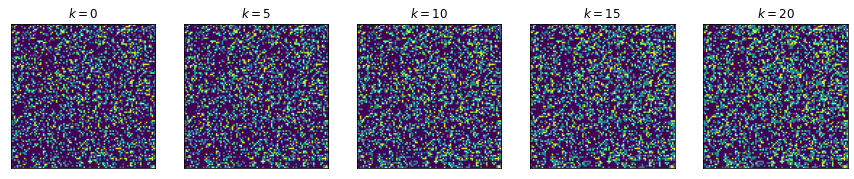

In [3]:
fig, ax = plt.subplots(1, 5, figsize=(15, 3), sharex=True, sharey=True)
for k in range(len(ax)):
    ax[k].imshow(lattices[k*5])
    ax[k].set_xticks([])
    ax[k].set_yticks([])
    ax[k].set_title(fr"$k={k*5}$")

In [7]:
def lattice_distance_l2(l1, l2):
    """
    L2 distance between two given lattices.
    """
    return np.linalg.norm(l1-l2)


lattices_flat = np.row_stack([lattice.ravel() for lattice in lattices])
print("data shape", lattices_flat.shape)
# d_l2 = scipy.spatial.distance.pdist(lattices_flat, metric=lattice_distance_l2)
# d_l2 = scipy.spatial.distance.squareform(d_l2)

# print("distance matrix shape", d_l2.shape)

rng = np.random.default_rng(1)
U = rng.normal(loc=0, scale=1, size=(lattices_flat.shape[1], 100))
U, _, _ = np.linalg.svd(U, full_matrices=False)

lattices_flat_reduced = lattices_flat @ U

print("lattices_flat_reduced shape", lattices_flat_reduced.shape)

data shape (10387, 10000)
lattices_flat_reduced shape (10387, 100)


(20, 10387)
[10774.44920805   114.24300574   110.59101443   108.6734416
   104.56405589   100.97178988   100.10100851    98.11733394
    96.43449068    94.0525542     92.61582756    90.01958019
    88.15659858    84.47008069    83.40007458    83.1226
    79.93110932    79.47019123    79.11260806    77.34536896]


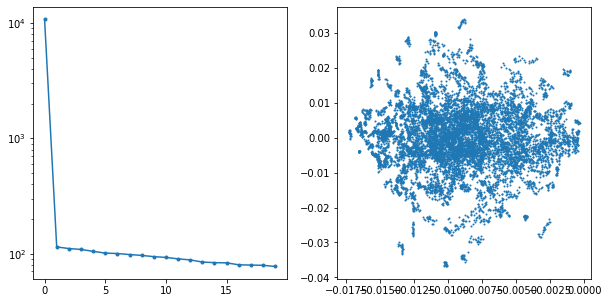

In [8]:
# try simple PCA first
pca = PCA(n_components=20)
pca.fit(lattices_flat_reduced.T)

print(pca.components_.shape)
print(pca.explained_variance_)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].semilogy(pca.explained_variance_, '.-')
ax[1].scatter(*pca.components_[:2, :], s=1)
# ax[1].set_aspect(.3)

Optimize hyperparameters.
Computing Diffusion Maps.


C:\Users\Felix Dietrich\pythonenvs\datafold\lib\site-packages\scipy\sparse\_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Plotting results.


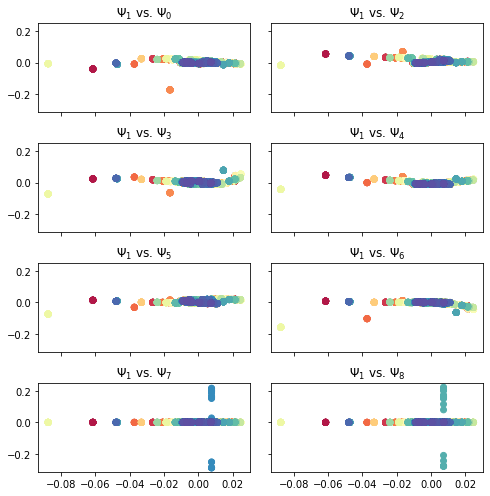

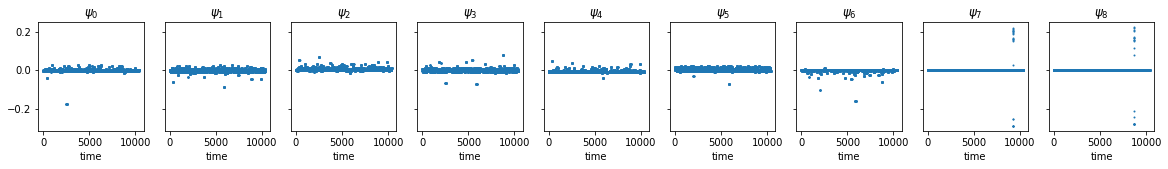

In [11]:
# compute dmaps
pcm = pfold.PCManifold(pca.components_.T)

print("Optimize hyperparameters.")
pcm.optimize_parameters(n_subsample=100)

kmin = 10
print("Computing Diffusion Maps.")
dmap = dfold.DiffusionMaps(n_eigenpairs=9,
                           kernel=pfold.kernels.ContinuousNNKernel(k_neighbor=kmin, delta=1.0),
                           dist_kwargs={"kmin": kmin, "cut_off": 1e-16})
dmap.fit(pcm)

print("Plotting results.")
# plot results
plot_pairwise_eigenvector(
    eigenvectors=dmap.eigenvectors_,
    n=1,
    fig_params=dict(figsize=[7, 7]),
    scatter_params=dict(cmap=plt.cm.Spectral, c=np.arange(0, pcm.shape[0])/pcm.shape[0]),
)
fig = plt.gcf()
fig.tight_layout()

# also plot against the time
time = np.arange(0, pcm.shape[0])
fig, ax = plt.subplots(1, dmap.eigenvectors_.shape[1], figsize=(20, 2), sharex=True, sharey=True)
for k in range(len(ax)):
    ax[k].scatter(time, dmap.eigenvectors_[:, k], s=1)
    ax[k].set_title(fr"$\psi_{k}$")
    ax[k].set_xlabel("time")